In [1]:
import MySQLdb
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
%matplotlib inline

In [3]:
!ls data/data

cb_acquisitions.sql   cb_investments.sql    cb_offices.sql
cb_degrees.sql        cb_ipos.sql           cb_people.sql
cb_funding_rounds.sql cb_milestones.sql     cb_relationships.sql
cb_funds.sql          cb_objects.sql        license.txt


In [4]:
# variables for database connection
dsn_database = "p3"   
dsn_uid = "root"             
dsn_pswd = "I prefer prequels"            

In [5]:
def db_connect(dsn_uid,dsn_pswd,dsn_database):
    # connect to database
    conn = MySQLdb.connect(user=dsn_uid, passwd=dsn_pswd, db=dsn_database)
    cursor=conn.cursor()
    return conn,cursor

In [6]:
def db_read(connection,table):
    conn,cursor = connection
    with conn as cursor:
        cursor.execute('SELECT * FROM {}'.format(table))
        fields = [item[0] for item in cursor.description]
        result = []
        columns = tuple( [item[0] for item in cursor.description] )
        for row in cursor:
            result.append(dict(zip(columns, row)))
        result_df = pd.DataFrame(result)
    return result_df

In [7]:
connection = db_connect(dsn_uid,dsn_pswd,dsn_database)
people = db_read(connection,'cb_people')
degrees = db_read(connection,'cb_degrees')
funding_rounds = db_read(connection,'cb_funding_rounds')
objects = db_read(connection,'cb_objects')

/Users/mitch/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: context interface will be changed.  Use explicit conn.commit() or conn.rollback().
  app.launch_new_instance()


In [8]:
print(objects.columns)
print(people.columns)

Index(['category_code', 'city', 'closed_at', 'country_code', 'created_at',
       'created_by', 'description', 'domain', 'entity_id', 'entity_type',
       'first_funding_at', 'first_investment_at', 'first_milestone_at',
       'founded_at', 'funding_rounds', 'funding_total_usd', 'homepage_url',
       'id', 'invested_companies', 'investment_rounds', 'last_funding_at',
       'last_investment_at', 'last_milestone_at', 'logo_height', 'logo_url',
       'logo_width', 'milestones', 'name', 'normalized_name', 'overview',
       'parent_id', 'permalink', 'region', 'relationships',
       'short_description', 'state_code', 'status', 'tag_list',
       'twitter_username', 'updated_at'],
      dtype='object')
Index(['affiliation_name', 'birthplace', 'first_name', 'id', 'last_name',
       'object_id'],
      dtype='object')


## The most successful businesses

If we consider a successful business to be one that has raised the most capital through a variety of funding rounds, we can sort our dataset accordingly.

We can get the total raised by a company by using the `funding_total_usd` column in the objects database. Note that we only want to use companies, so we only select those with an `entity_type` of "company". We will also reduce the size of our dataframe to include only a couple important metrics.

In [9]:
companies = objects[objects.entity_type=='Company'][['name','entity_id','funding_total_usd','closed_at']].copy()
# Only select companies who have raised some money
companies = companies.dropna(subset=['funding_total_usd'])
display(companies.sort_values('funding_total_usd',ascending=False).head(20))

comp_tot = len(companies)
print('There are {:,} companies in the dataset'.format(comp_tot))

,name,entity_id,funding_total_usd,closed_at
4575,Clearwire,13219,5700000000,None
160023,"Verizon Communications, Inc.",4843,3985050000,None
97784,sigmacare,242735,2600000000,None
161551,Facebook,5,2425700000,None
175825,Carestream,64365,2400000000,None
81001,Solyndra,22568,1765504319,None
170979,Fisker Automotive,5951,1451000000,None
151715,O3b Networks,39799,1270283000,None
101987,Terra-Gen Power,24693,1200000000,None
2971,Twitter,12,1160166511,None


There are 27,874 companies in the dataset


Now that we have all of the companies, let's define exactly what we mean by the most successful companies. First, to get a feel for the data visually, let's look at the top 100 companies and their fundraising totals.

/Users/mitch/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


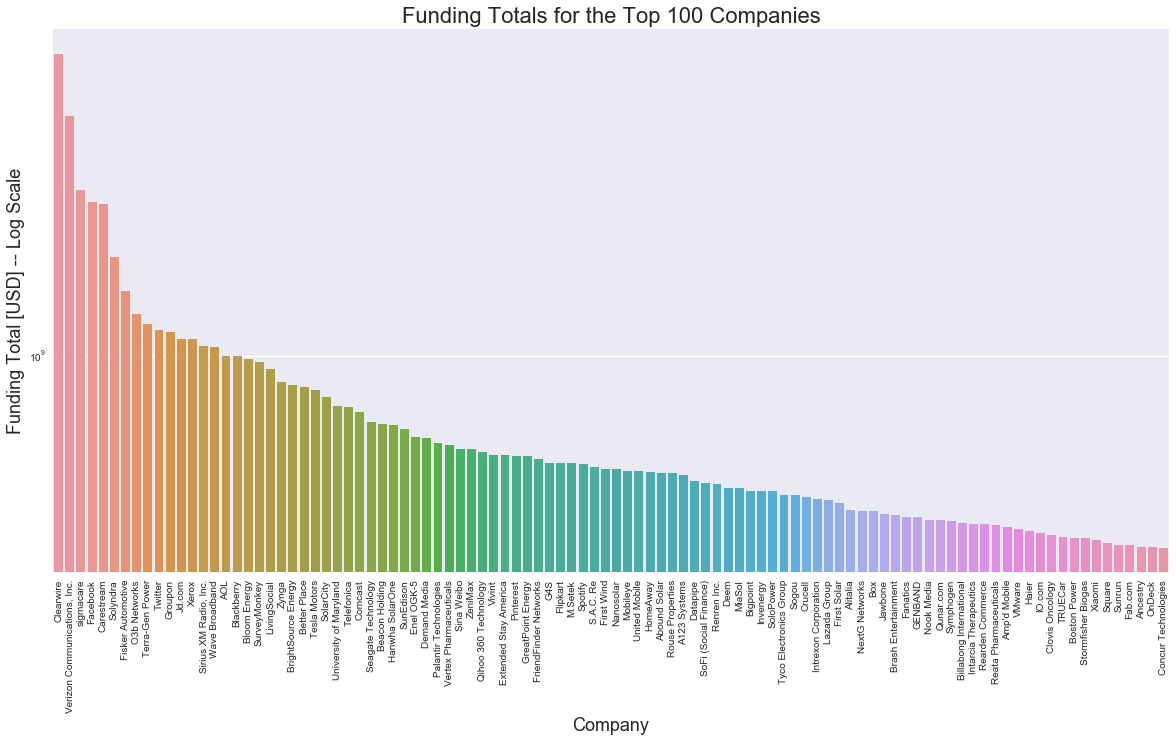

In [10]:
fig,ax = plt.subplots(figsize=(20,10))
n_top_companies = 100
plotset = companies.sort_values('funding_total_usd',ascending=False).head(n_top_companies)
ax = sns.barplot(x='name',y='funding_total_usd',data=plotset)
ax.set_title('Funding Totals for the Top {} Companies'.format(n_top_companies),fontsize=22)
ax.set_xticklabels(labels=plotset.name,rotation='vertical')
ax.set_xlabel('Company',fontsize=18)
ax.set_yscale('log')
ax.set_ylabel('Funding Total [USD] -- Log Scale',fontsize=18);

It appears that only a handful of the companies fundraise greater than \$1 billion (\$$10^9$), though many more companies appear to fundraise in the millions. Let's find the exact percent of companies for each order of magnitude.

In [11]:
I,F = 3,10
for i in np.logspace(I,F,F-I+1):
    num_above = len(companies[companies['funding_total_usd']>i])
    frac = num_above/comp_tot
    print('{:,} companies ({}%) above ${:,}'.format(num_above,round(100*frac,1),int(i)))

27,854 companies (99.9%) above $1,000
27,608 companies (99.0%) above $10,000
24,960 companies (89.5%) above $100,000
18,112 companies (65.0%) above $1,000,000
7,309 companies (26.2%) above $10,000,000
630 companies (2.3%) above $100,000,000
15 companies (0.1%) above $1,000,000,000
0 companies (0.0%) above $10,000,000,000


We see from this that only slightly more than 25% of the companies fundraise more than $10 million. Let's define these 7309 companies as the most successful.

## The people behind the most successful businesses

Next, we can use the people database to pair individuals with the company they are affiliated with. Like for the funding rounds data, we don't need all of the information provided in the database of people either. Since we ultimately want to look at educational factors, let's limit the dataset to only a person's name (first and last), `object_id`, and affiliation, in a key that will let us link to the degrees dataset.

In [12]:
people_key = people[['affiliation_name','first_name','last_name','object_id']]
display(people_key.head(10))

ppl_tot = len(people_key)
print('There are {:,} people in the dataset'.format(ppl_tot))

,affiliation_name,first_name,last_name,object_id
0,Blue Nile,Ben,Elowitz,p:2
1,Wetpaint,Kevin,Flaherty,p:3
2,Zoho,Raju,Vegesna,p:4
3,Zoho,Ian,Wenig,p:5
4,i/o Ventures,Kevin,Rose,p:6
5,Digg,Jay,Adelson,p:7
6,Digg,Owen,Byrne,p:8
7,Digg,Ron,Gorodetzky,p:9
8,Facebook,Mark,Zuckerberg,p:10
9,Facebook,Dustin,Moskovitz,p:11


There are 226,709 people in the dataset


Now we merge the two datasets together to get each funded company and people in the crunchbase dataset who were involved.

In [13]:
company_people = pd.merge(companies,people_key,left_on='name',right_on='affiliation_name').drop(columns='affiliation_name')
display(company_people.head())

cp_tot = len(company_people)
print('There are {:,} people affiliated with funded companies in the dataset'.format(cp_tot))

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id
0,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3
1,Wetpaint,1,39750000,None,Alex,Weinstein,p:104800
2,FriendFeed,1001,5000000,None,Paul,Buchheit,p:640
3,FriendFeed,1001,5000000,None,Sanjeev,Singh,p:2716
4,Fitbit,10015,68069200,None,James,Park,p:16930


There are 12,168 people affiliated with funded companies in the dataset


Interestingly, there are significantly fewer people associated with companies than there are people in the dataset.

We can now repeat the merging process with the dataset of educational information. First, let's limit the degrees dataset to include only degree type, institution, subject, and the id of the corresponding person (`object_id`). Then, we merge this into the database of companies and people.

In [14]:
edu = degrees[['object_id','institution','degree_type','subject']].dropna(subset=['institution'])
CPE = pd.merge(company_people,edu,on='object_id')
display(CPE.head(10))

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id,institution,degree_type,subject
0,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Washington University in St Louis,BBA,None
1,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Indiana University,MBA,None
2,FriendFeed,1001,5000000,None,Paul,Buchheit,p:640,Case Western Reserve University,MS,Computer Science
3,FriendFeed,1001,5000000,None,Sanjeev,Singh,p:2716,Stanford University,BS,Computer Science
4,Fitbit,10015,68069200,None,James,Park,p:16930,Harvard University,DNF,Computer Science
5,Fitbit,10015,68069200,None,Eric,Friedman,p:16931,George Washington University,BBA,Business Marketing
6,Fitbit,10015,68069200,None,Meena,Srinivasan,p:89236,"India, Certified Public Accountant in California",Chartered Accountant,None
7,Fitbit,10015,68069200,None,Meena,Srinivasan,p:89236,East Carolina University,MBA,None
8,Fitbit,10015,68069200,None,Mark,Silverio,p:121130,Boston College,BS,Marketing
9,Fitbit,10015,68069200,None,Eric,Friedman,p:216979,Yale University,MS,Computer Science


Finally, we filter the dataset of company, people, and education to only those in the most successful businesses (those who fundraised more than $10 million).

In [15]:
successful_CPE = CPE[CPE['funding_total_usd']>10_000]
display(successful_CPE.head())

n_entries = len(CPE)
n_unique_ppl = CPE['object_id'].nunique()
print('There are {:,} entries in the dataset, and {:,} unique people in the dataset.'.format(n_entries,n_unique_ppl))
print('On average, successful businesses involve people with an average of {} degrees.'.format(round(n_entries/n_unique_ppl,1)))

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id,institution,degree_type,subject
0,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Washington University in St Louis,BBA,None
1,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Indiana University,MBA,None
2,FriendFeed,1001,5000000,None,Paul,Buchheit,p:640,Case Western Reserve University,MS,Computer Science
3,FriendFeed,1001,5000000,None,Sanjeev,Singh,p:2716,Stanford University,BS,Computer Science
4,Fitbit,10015,68069200,None,James,Park,p:16930,Harvard University,DNF,Computer Science


There are 10,823 entries in the dataset, and 6,768 unique people in the dataset.
On average, successful businesses involve people with an average of 1.6 degrees.


We see that out of the 12,168 people in the full dataset, more than half are associated with well performing businesses. We also see that it is quite common for those at successful businesses to have multiple degrees.

# (Not so) humble beginnings

Next we take a look at the institutions who have produced the people affiliated with the successful businesses. If we were to take a closer look at the table above, you would see that many of the institutions are duplicated, but often with slight variations for each school.

In [35]:
#for inst in np.sort(CPE['institution'].unique()):
#    print(inst)

We will try to eliminate some of these duplicates, while at the same time reducing the names in such a way that we can properly aggregate a school when it is named alternatively.

In [37]:
# Define stopwords, punctuation and word stems
stopwords = ['of','the','at','in','i','y','and','de','@']
stoppunc = [',','\.',';',':','-','&','(',')','/']
stems = ['poly','tec','cal','inst','agri','coll']
delstems = ['univ','school','law','business']

In [36]:
# Also define some famous keywords or alternate names that clearly identify a specific school
famous_keywords=['wharton','yale','harvard','mit','henley','berkeley','gurion','duke',
             'babson','bentley','canberra','boulder','stanford','northwestern','usc',
             'ucla','nyu','bowling green','baldwin wallace','boston coll','cal culinary',
             'virginia commonwealth','virginia poly','stony brook','georgia tec']
famous_altnames={'cal':'berkeley','pennsylvania':'penn','wharton':'penn','virginia poly':'virginia tec',
                 'chicago booth':'chicago','massachusetts inst tec':'mit'}

In [32]:
# Make all words lowercase
inst=CPE['institution'].str.lower()

#Remove stopwords
for word in stopwords:
    inst = inst.str.replace(' '+word+' ',' ')
inst = inst.str.replace('\Athe ','')

# Remove punctuation
for punc in stoppunc:
    inst = inst.str.replace(punc,' ')
inst = inst.str.strip()

# Replace common stems with just the stem, delete others, and replace keywords and nicknames with a common title.
inst = inst.str.split()
for school_i in range(len(inst)):
    # Delete superfluous words
    del_word_inds = []
    for word_i in range(len(inst[school_i])):
        for delstem in delstems:
            if inst[school_i][word_i][:len(delstem)]==delstem:
                del_word_inds.append(word_i)
    for word_i in del_word_inds[::-1]:
        del(inst[school_i][word_i])
    # Reduce words to their stems
    for word_i in range(len(inst[school_i])):
        for stem in stems:
            if inst[school_i][word_i][:len(stem)]==stem:
                inst[school_i][word_i]=stem
    # Replace names with a common name when a keyword is present
    for name in famous_keywords:
        match_counter = 0 
        names = name.split()
        for word in names:
            if word in inst[school_i]:
                match_counter += 1
            if match_counter == len(names):
                inst[school_i]=names
    # Replace a nickname with a common name if a nickname is given
    for name in famous_altnames:
        match_counter = 0
        names = name.split()
        for word in names:
            if word in inst[school_i]:
                match_counter +=1
        if match_counter == len(inst[school_i]) and match_counter == len(names):
            inst[school_i]=[famous_altnames[name]]
            break       
CPE.institution=inst.str.join(' ')

This dataset is still quite large by itself. To reduce it's size, we will only focus on those schools which have contributed more than 10 people to successful businesses.

In [41]:
people_contributed_min = 10
inst_counts = pd.DataFrame(CPE.institution.value_counts())
inst_mult = inst_counts[inst_counts.institution>people_contributed_min]
inst_mult = inst_mult.rename(columns={'institution':'count'})
CPE_count = pd.merge(CPE,inst_mult,left_on='institution',right_index=True).sort_values('count',ascending=False)
CPE_count.head()

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id,institution,degree_type,subject,count
10541,Mozilla,900,2300000,None,Ellen,Siminoff,p:13067,stanford,MBA,Business,618
6854,Strutta,4363,1583167,None,Ben,Pickering,p:42348,stanford,MBA,None,618
6863,TokBox,437,26000000,None,Badri,Rajasekar,p:55381,stanford,MS,Computer Science,618
6919,Counsyl,44089,65200000,None,Eric,Evans,p:160991,stanford,PhD,Genetics,618
6921,Counsyl,44089,65200000,None,Rishi,Kacker,p:167982,stanford,BS,Computer Science,618


To make more sense of this dataset, we will plot according to universities which have contributed the most people to successful businesses.

/Users/mitch/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


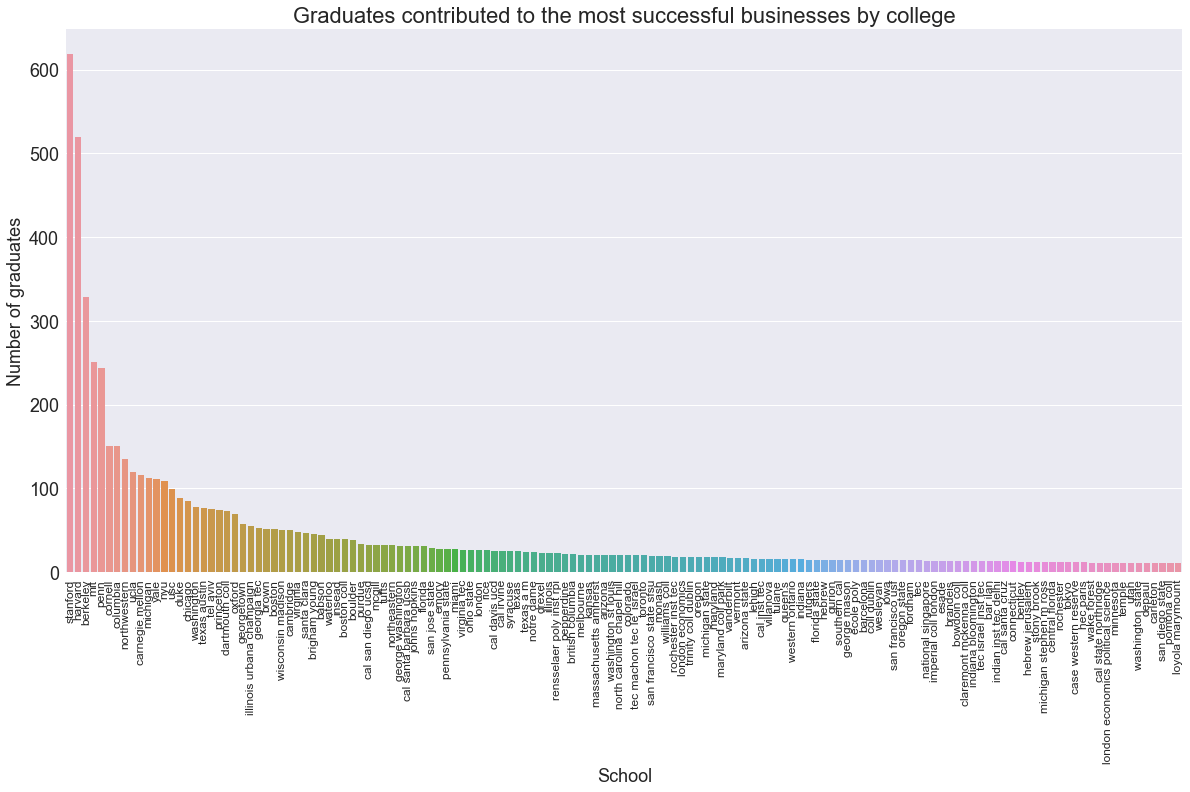

In [44]:
fig,edu_ax = plt.subplots(figsize=(20,10))
edu_ax = sns.barplot(x='institution',y='count',data=CPE_count)
edu_ax.set_title('Graduates contributed to the most successful businesses by college',fontsize=22)
edu_ax.tick_params(labelsize=18)
edu_ax.set_xticklabels(labels=CPE_count.institution.unique(),rotation='vertical',fontsize=12)
edu_ax.set_xlabel('School',fontsize=18)
edu_ax.set_ylabel('Number of graduates',fontsize=18);